# Use T-SQL to push data into a Power BI streaming dataset via REST endpoint

Power BI allows the data to be pushed into a streaming dataset by using a REST endpoint.

This sample assumes that a streaming dataset in Power BI has already been created. The sample here is called StatusInfo.

## Get the dataset details

From the list of resources in a Power BI workspace, the API Info information can be shown using the menu availlable by clicking on the ellipsis (...) button.

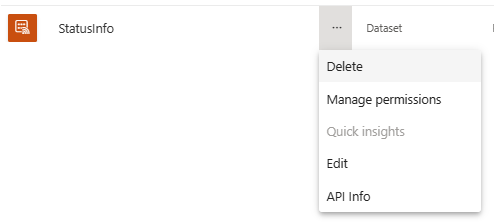

The details shown will display something like the following:

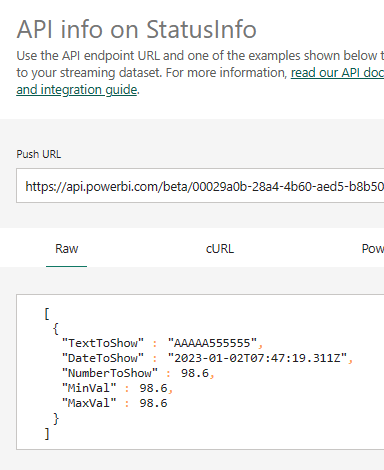

## Calling the API from T-SQL

Having taken note of the Push URL and the values required, you are ready to call sp\_invoke\_external\_rest\_endpoint. All that is needed is to construct a JSON string from the values and make the call.

To simply the calls, a stored procedure dbo.PushToPBIStream has been created to create the JSON and make the call. The URL has been truncated. 

The @payload variable has been populated by simply querying the values without a FROM clause, using column names as per the dataset as shown in the Power BI screenshot above. FOR JSON PATH does the rest, and our payload is ready to pass into sp\_invoke\_external\_rest\_endpoint.

A stored procedure to simulate a long process, called dbo.LongRunningProcedure, has been created which calls dbo.PushToPBIStream at key points in the procedure.

In [ ]:
SET ANSI_NULLS ON
GO
SET QUOTED_IDENTIFIER ON
GO
CREATE OR ALTER proc [dbo].[PushToPBIStream] (@Text varchar(1000) = null, @Value int = null, @DateTime datetime = null, @returnval int = null output)
as
begin

declare @payload nvarchar(max) = (
select @Text as TextToShow
    , @Value as NumberToShow
    , @DateTime as DateToShow
    , 0 as MinVal
    , 100 as MaxVal
for json path
);

declare @response nvarchar(max);

EXEC @returnval = sp_invoke_external_rest_endpoint 
 @url = N'https://api.powerbi.com/beta/.....'
,@payload = @payload
,@method = 'POST'
,@response = @response output;
; 
/*
select *
from openjson(@response) r
cross apply openjson(r.value) v
*/
select @payload;


end
GO

CREATE OR ALTER proc [dbo].[LongRunningProcedure]
as
begin

declare @Now datetime;

set @Now = getdate()
exec dbo.PushToPBIStream @Value=0, @DateTime = @Now, @Text = 'Just started';

--Do lots of work
waitfor delay '00:00:05'

set @Now = getdate()
exec dbo.PushToPBIStream @Value=50, @DateTime = @Now, @Text = 'We''re livin'' on a prayer!';

--Do lots more work
waitfor delay '00:00:05'

set @Now = getdate()
exec dbo.PushToPBIStream @Value=100, @DateTime = @Now, @Text = 'And we''re done';

end

Now the streaming Power BI dataset can be monitored.

Part way through the execution of dbo.LongRunningProcedure, a gauge control appears thus:

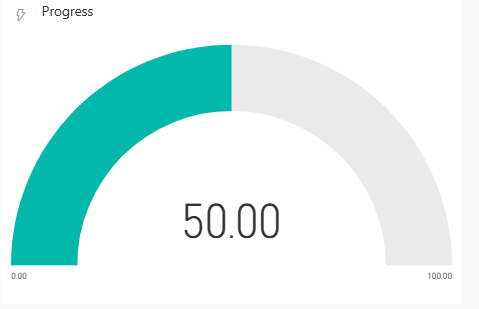  

And then at the end, it appears thus:

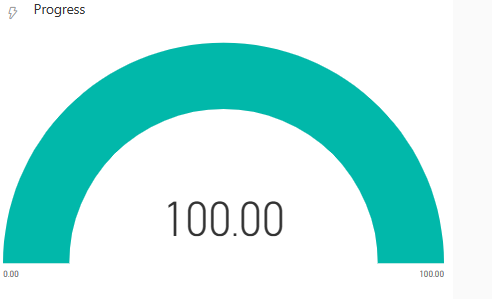  

This therefore demonstrates the ease with which data can be pushed into a Power BI streaming dataset from within T-SQL.